In [1]:
import numpy as np
#from scipy.signal import butter, filtfilt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
#import seaborn as sns
#sns.set_context("notebook", font_scale=1.3,
#                rc={'lines.linewidth': 1.5, 'lines.markersize': 14, 'axes.titlesize': 'x-large'})
#matplotlib.rc('legend', numpoints=1, fontsize=14)
#import glob
import sys, os
sys.path.insert(1, r'./Functions')
# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive
import seaborn as sns
from scipy.signal import detrend

In [2]:
#!pip install version_information
%load_ext version_information
%version_information numpy, scipy, pandas, matplotlib, seaborn

Software versions
Python 3.8.8 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.22.0
OS Windows 10 10.0.22000 SP0
numpy 1.20.1
scipy 1.6.2
pandas 1.2.4
matplotlib 3.3.4
seaborn 0.11.1
Sat Oct 15 11:09:50 2022 Hora oficial do Brasil

In [3]:
# GitHub URL:
#path2 = 'C:\Users\ferna\Downloads\IC- dados\Dados'
# local directory:
path2 = r'C:\\Users\\ferna\\Downloads\\IC- dados\\Dados'
fname = os.path.join(path2, 'PDSinfo.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print(fname)
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(PDSinfo.Subject)), PDSinfo.shape[0], PDSinfo.shape[1]))

C:\\Users\\ferna\\Downloads\\IC- dados\\Dados\PDSinfo.txt
Information of 49 subjects loaded (588 rows, 29 columns).


In [4]:
a=PDSinfo[PDSinfo['Subject']==44].index.tolist()
e=PDSinfo[PDSinfo['Subject']==44].index.tolist()[2]

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPYreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))

d1x = np.zeros((49, 60*fs-30))
d2x = np.zeros((49, 60*fs-30))

d1z = np.zeros((49, 60*fs-30))
d2z = np.zeros((49, 60*fs-30))

matrizangx = np.zeros((49, 60*fs-30))
matrizangz = np.zeros((49, 60*fs-30))

alpha = np.zeros((49, 60*fs-30))

COGX = np.zeros((49, 60*fs-30))
COGY = np.zeros((49,60*fs-30))
COGZ = np.zeros((49, 60*fs-30))  

for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    colunas = mkr.columns
    print(list(colunas))
    COGX[s-1,:]=mkr['COG_X'].values[30:]
    COGY[s-1,:]=mkr['COG_Y'].values[30:]
    COGZ[s-1,:]=mkr['COG_Z'].values[30:]
    #print(COGX)
    mass=PDSinfo['Mass']
    d = np.sqrt(COGX[s-1,:]**2+COGY[s-1,:]**2+COGZ[s-1,:]**2)
    angulox = np.arcsin(COGX[s-1,:]/d)
    anguloz= np.arcsin(COGZ[s-1,:]/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[s-1,:] = angulox
    matrizangz[s-1,:] = anguloz
    
    
    Jb=(4/3)*(mass.values[s])*((d)**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[s-1,:]=np.gradient(matrizangx[s-1,:],dt)
    d1z[s-1,:]=np.gradient(matrizangz[s-1,:],dt)

    d2x[s-1,:]=np.gradient(d1x[s-1,:],dt)
    d2z[s-1,:]=np.gradient(d1z[s-1,:],dt)
    
    COPX[s-1,:] = d*sinx + Jb/(mass.values[s]*9.8)*(sinx*d1x[s-1,:]**2-cosx*d2x[s-1,:])
    COPZ[s-1,:] = d*sinz + Jb/(mass.values[s]*9.8)*(sinz*d1z[s-1,:]**2-cosz*d2z[s-1,:])
    
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    

    
    x= np.vstack((COPX[[s-1],:],d2x[[s-1],:]))
    y= COPXreal[s-1,:]

    model=LinearRegression(fit_intercept=False)
    model.fit(x.T,y)
    
    
    split=train_test_split(COGX,COPXreal,test_size=9)
    COGXtrain = split[0]
    COPXtrain = split[1]
    COGXtest = split[2]
    COPXtest = split[3]
    
#print(COGXtrain)
#for i in COGXtrain:
 #   i=0
#print(COGXtrain[i])
    
    
    
    
    #print(model.coef_) 
    
    #def reg_m(y, x):
        #ones = np.ones(len(x[0]))
        #X = sm.add_constant(np.column_stack((x[0], ones)))
        #for oi in x[1:]:
            #X = sm.add_constant(np.column_stack((oi, X)))
            #results = sm.OLS(y, x).fit()
            #return results
    #print(model.coef_)
    #print(reg_m(y, x.T).summary())
 
    #print(model.coef_)
    #x= (np.array([COPX[s-1,:],d2x[s-1,:]]))
    #y= COPXreal[s-1,:]
    #model=LinearRegression()
    #model.fit(x.T,y)
    #print(model.coef_) 
    #Histogramas
    #plt.figure()
    #hist=plt.hist(model.coef_[0], bins=50)
    #plt.title('Histograms of alpha'.format(s))
    #plt.show()


['Time', 'R.Front.Head_X', 'R.Front.Head_Y', 'R.Front.Head_Z', 'L.Front.Head_X', 'L.Front.Head_Y', 'L.Front.Head_Z', 'R.Back.Head_X', 'R.Back.Head_Y', 'R.Back.Head_Z', 'L.Back.Head_X', 'L.Back.Head_Y', 'L.Back.Head_Z', 'R.Shoulder_X', 'R.Shoulder_Y', 'R.Shoulder_Z', 'L.Shoulder_X', 'L.Shoulder_Y', 'L.Shoulder_Z', 'C7_X', 'C7_Y', 'C7_Z', 'T2_X', 'T2_Y', 'T2_Z', 'T7_X', 'T7_Y', 'T7_Z', 'L1_X', 'L1_Y', 'L1_Z', 'L3_X', 'L3_Y', 'L3_Z', 'L5_X', 'L5_Y', 'L5_Z', 'IJ_X', 'IJ_Y', 'IJ_Z', 'PX_X', 'PX_Y', 'PX_Z', 'R.ASIS_X', 'R.ASIS_Y', 'R.ASIS_Z', 'L.ASIS_X', 'L.ASIS_Y', 'L.ASIS_Z', 'R.PSIS_X', 'R.PSIS_Y', 'R.PSIS_Z', 'L.PSIS_X', 'L.PSIS_Y', 'L.PSIS_Z', 'L.Iliac.Crestv_X', 'L.Iliac.Crestv_Y', 'L.Iliac.Crestv_Z', 'R.Iliac.Crestv_X', 'R.Iliac.Crestv_Y', 'R.Iliac.Crestv_Z', 'R.GTR_X', 'R.GTR_Y', 'R.GTR_Z', 'L.GTR_X', 'L.GTR_Y', 'L.GTR_Z', 'R.Knee_X', 'R.Knee_Y', 'R.Knee_Z', 'R.Knee.Medialv_X', 'R.Knee.Medialv_Y', 'R.Knee.Medialv_Z', 'L.Knee_X', 'L.Knee_Y', 'L.Knee_Z', 'L.Knee.Medialv_X', 'L.Knee.Med

In [6]:

fs = 100 # Hz
COPX = np.zeros((0, 60*fs-30))
COPZ = np.zeros((0, 60*fs-30))

COPXreal = np.zeros((0, 60*fs-30))
COPYreal = np.zeros((0, 60*fs-30))
COPZreal = np.zeros((0, 60*fs-30))

d1x = np.zeros((0, 60*fs-30))
d2x = np.zeros((0, 60*fs-30))

d1z = np.zeros((0, 60*fs-30))
d2z = np.zeros((0, 60*fs-30))

matrizangx = np.zeros((0, 60*fs-30))
matrizangz = np.zeros((0, 60*fs-30))

alpha = np.zeros((0, 60*fs-30))

COGX = np.zeros((0, 60*fs-30))
COGY = np.zeros((0,60*fs-30))
COGZ = np.zeros((0, 60*fs-30)) 
 

subject = np.zeros((0,1))
j=0

for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()
    for i in range(len(a)):
        fname_grf = os.path.join(path2, PDSinfo.Trial[a[i]] + 'grf' + '.txt') 
        fname_mkr = os.path.join(path2, PDSinfo.Trial[a[i]] + 'mkr' + '.txt')
        grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
        mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
        
        if not np.any(np.isnan(mkr['COG_X'].values[30:])):
            COGX = np.vstack((COGX, mkr['COG_X'].values[30:]))
            COGY = np.vstack((COGY, mkr['COG_Y'].values[30:]))
            COGZ = np.vstack((COGZ, mkr['COG_Z'].values[30:]))
    
            mass=PDSinfo['Mass']
            d = np.sqrt(COGX[s-1,:]**2+COGY[s-1,:]**2+COGZ[s-1,:]**2)
            angulox = np.arcsin(COGX[s-1,:]/d)
            anguloz= np.arcsin(COGZ[s-1,:]/d)
            sinx=np.sin(angulox)
            sinz=np.sin(anguloz)
            cosx=np.cos(angulox)
            cosz=np.cos(anguloz)
            tanx=np.tan(angulox)
            tanz=np.tan(anguloz)
            matrizangx = np.vstack((matrizangx,angulox))
            matrizangz = np.vstack((matrizangz,anguloz))


            Jb=(4/3)*(mass.values[s])*((d)**2)
            t=grf['Time']
            dt=t[1]-t[0]

            d1x = np.vstack((d1x, np.gradient(matrizangx[s-1,:],dt)))
            d1z = np.vstack((d1z, np.gradient(matrizangz[s-1,:],dt)))

            d2x = np.vstack((d2x, np.gradient(d1x[s-1,:],dt)))
            d2z = np.vstack((d2z, np.gradient(d1z[s-1,:],dt)))

            COPX = np.vstack((COPX, d*sinx + Jb/(mass.values[s]*9.8)*(sinx*d1x[s-1,:]**2-cosx*d2x[s-1,:])))
            COPZ = np.vstack((COPZ, d*sinz + Jb/(mass.values[s]*9.8)*(sinz*d1z[s-1,:]**2-cosz*d2z[s-1,:])))


            COPXreal = np.vstack((COPXreal, grf['COPNET_X'].values[30:]))
            COPZreal = np.vstack((COPZreal, grf['COPNET_Z'].values[30:]))
            
            subject = np.vstack((subject, [s]))
    

    
print(COGX.shape)
print(COPX.shape)

(574, 5970)
(574, 5970)


In [7]:
indices = np.arange(1,50).reshape(-1,1)
np.random.shuffle(indices)
train = indices[:40]
test = indices[40:]



np.in1d(subject,train)
COGXtrain = COGX[np.in1d(subject,train),:]
COGXtest = COGX[np.in1d(subject,test),:]
COPXtrain = COPX[np.in1d(subject,train),:]
COPXtest = COPX[np.in1d(subject,test),:]
COGYtrain = COGY[np.in1d(subject,train),:]
COGYtest = COGY[np.in1d(subject,test),:]

COGZtrain = COGZ[np.in1d(subject,train),:]
COGZtest = COGZ[np.in1d(subject,test),:]
COPZtrain = COPZ[np.in1d(subject,train),:]
COPZtest = COPZ[np.in1d(subject,test),:]

print(COGZtrain.shape)

(466, 5970)


In [8]:
from sklearn.model_selection import train_test_split
alpha= []
beta=[]
for i in range(0,len(COGXtrain)):
    d = np.sqrt(COGXtrain[i]**2+COGYtrain[i]**2+COGZtrain[i]**2)
    angulox = np.arcsin(COGXtrain[i]/d)
    anguloz = np.arcsin(COGZtrain[i]/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[i,:] = angulox
    matrizangz[i,:] = anguloz
    
    Jb=(4/3)*(mass.values[s])*((d)**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[i,:]=np.gradient(matrizangx[i,:],dt)
    d1z[i,:]=np.gradient(matrizangz[i,:],dt)
    
    

    d2x[i,:]=np.gradient(d1x[i,:],dt)
    d2z[i,:]=np.gradient(d1z[i,:],dt)
    
    COPX[i,:] = d*sinx + Jb/(mass.values[s]*9.8)*(sinx*d1x[i,:]**2-cosx*d2x[i,:])
    COPZ[i,:] = d*sinz + Jb/(mass.values[s]*9.8)*(sinz*d1z[i,:]**2-cosz*d2z[i,:])
    
    
    x= np.vstack((COPX[i,:],d2x[i,:]))
    y= COPXtrain[i,:]
    

    model=LinearRegression(fit_intercept=False)
    model.fit(x.T,y)
    print(model.coef_)
    alpha.append(model.coef_[0])
    
    beta.append(model.coef_[1])
   
alfamedia=np.mean(alpha)
betamedia=np.mean(beta)
print(alfamedia)
print(betamedia)

[1.00000000e+00 1.57111125e-17]
[0.97924407 0.1473665 ]
[0.96974421 0.15890063]
[0.910883   0.18737932]
[0.87940537 0.19677295]
[0.90557659 0.18599344]
[0.98043939 0.15815573]
[0.98607008 0.17046602]
[0.98390836 0.15881228]
[0.87571256 0.17971301]
[0.87103054 0.17734721]
[0.88260299 0.18402355]
[0.88342481 0.1823332 ]
[0.97138879 0.18818064]
[0.90106698 0.17781055]
[0.85453523 0.19483096]
[0.89535268 0.20817747]
[0.89084408 0.23401987]
[0.96839904 0.19515215]
[0.89330026 0.18636869]
[0.94375108 0.19625311]
[0.87424223 0.20696788]
[0.87584319 0.1977562 ]
[0.91468554 0.20083038]
[1.05676083 0.16158512]
[1.03893669 0.1384067 ]
[1.02215839 0.14669541]
[0.95227591 0.16716409]
[1.00906519 0.21318791]
[1.04783562 0.20791702]
[1.07308282 0.1530118 ]
[1.0502432  0.14601369]
[1.08067266 0.14769562]
[1.00603157 0.22287312]
[1.02549334 0.19475264]
[1.0383985  0.21123124]
[1.1370436  0.20725149]
[1.1260623  0.23457664]
[1.18325211 0.22572534]
[1.06434354 0.24719876]
[1.14201358 0.29446661]
[1.05256

(5970,)
[[0.26891523 0.26904968 0.2692072  ... 0.25509801 0.25541323 0.25561441]
 [0.26864874 0.26885595 0.26870683 ... 0.255081   0.25527203 0.25521405]
 [0.26032615 0.2603509  0.26037565 ... 0.24829902 0.24859596 0.24866539]
 ...
 [0.31009768 0.31489217 0.31174489 ... 0.30457905 0.30481283 0.30493277]
 [0.27022525 0.26922684 0.26764432 ... 0.28533938 0.2853287  0.28526122]
 [0.29079686 0.29136157 0.291977   ... 0.28688253 0.28889682 0.28996597]]
(108, 5970)
(108, 5970)


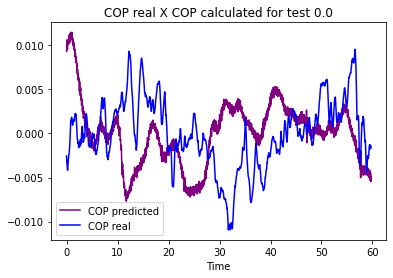

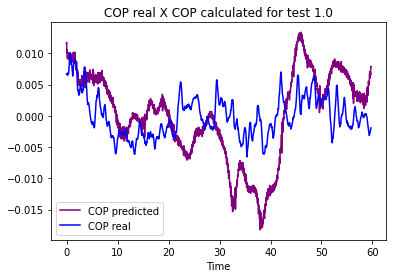

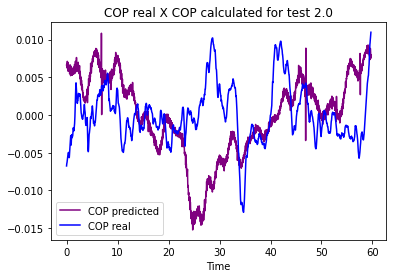

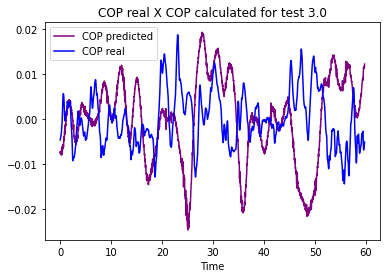

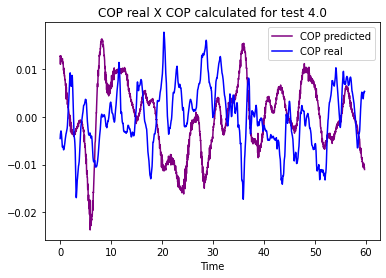

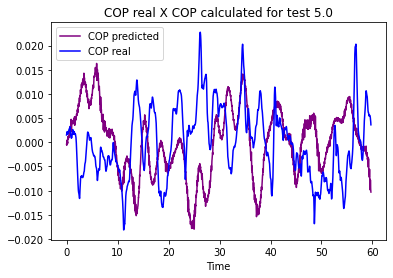

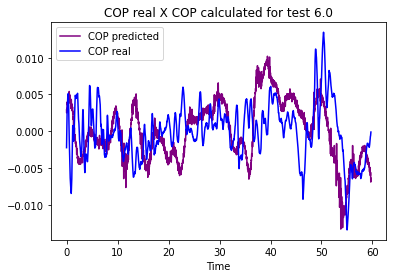

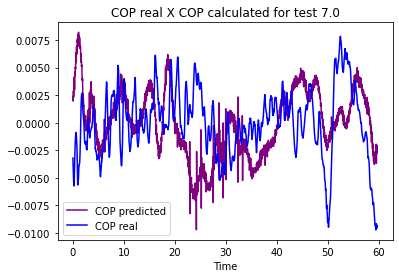

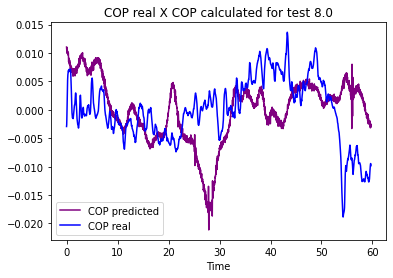

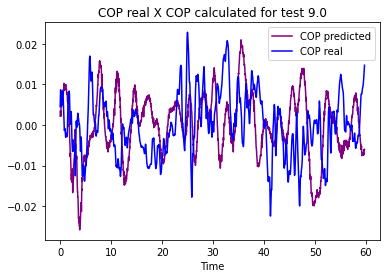

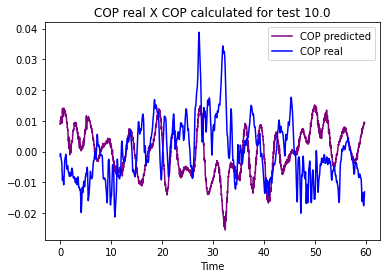

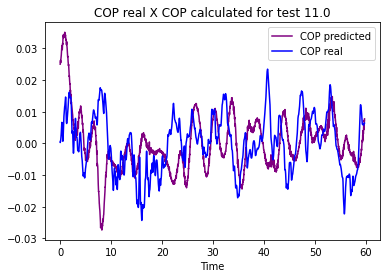

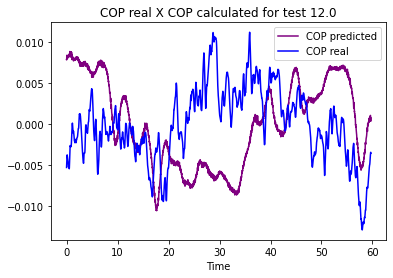

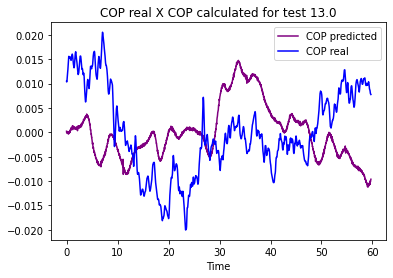

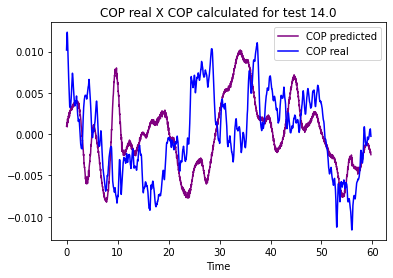

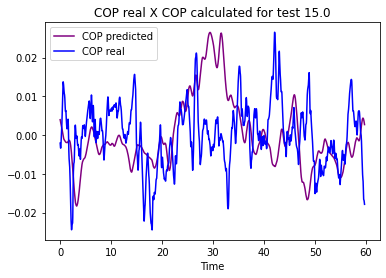

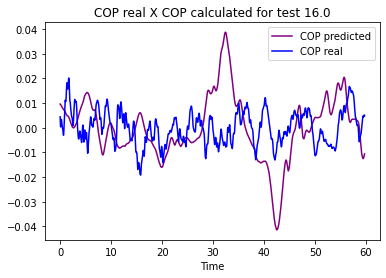

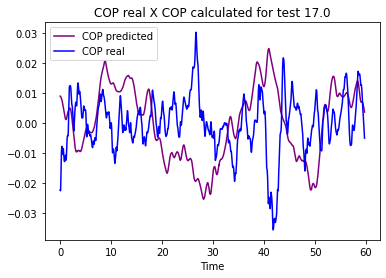

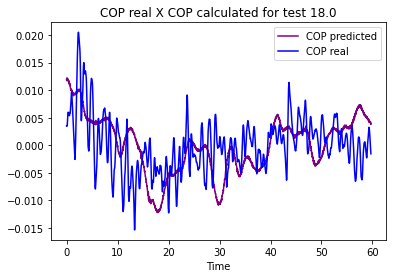

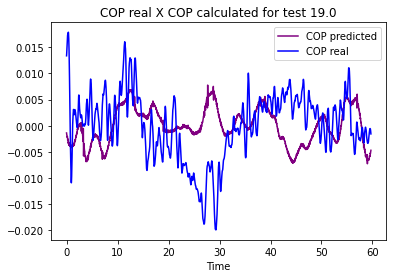

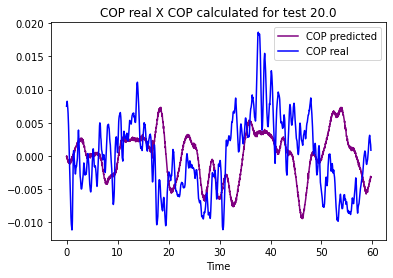

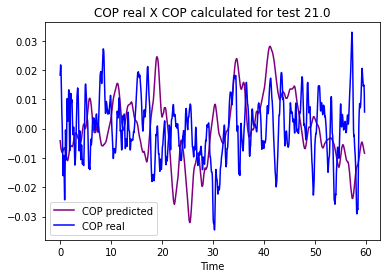

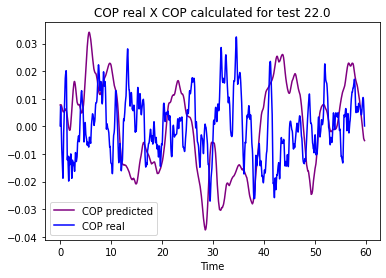

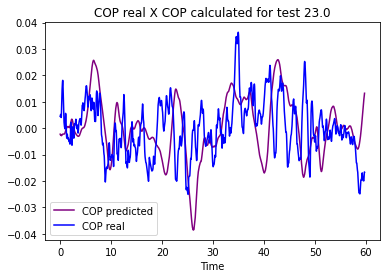

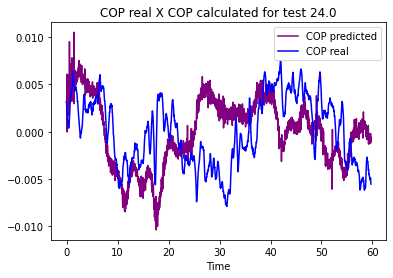

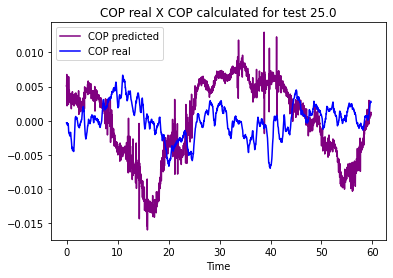

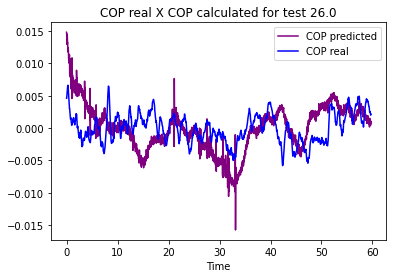

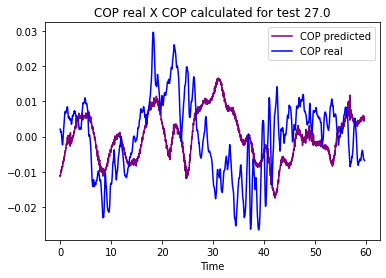

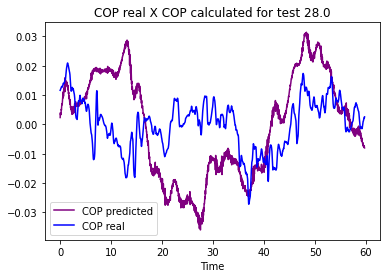

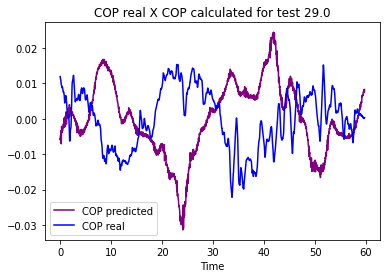

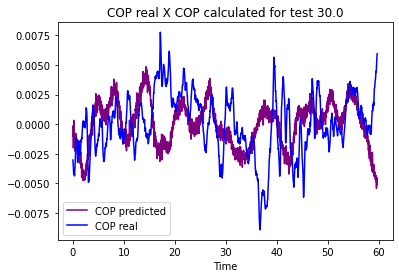

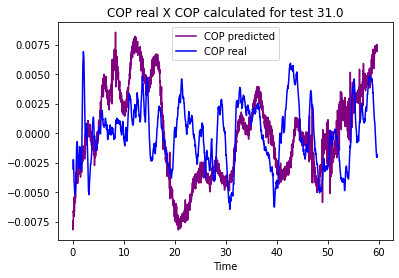

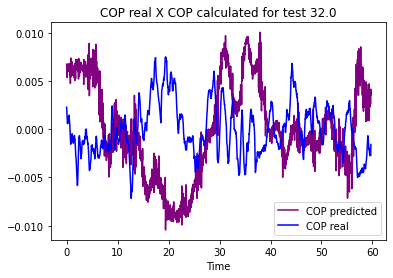

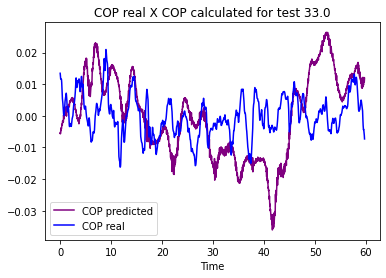

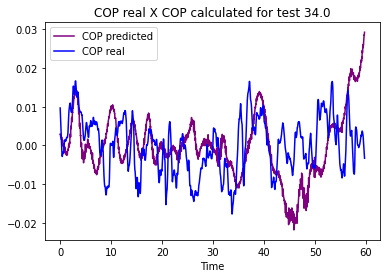

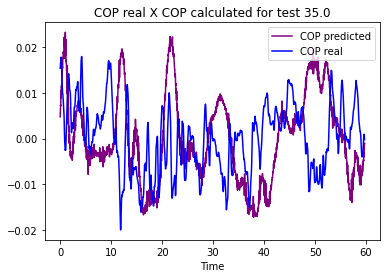

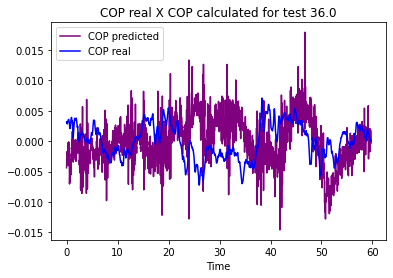

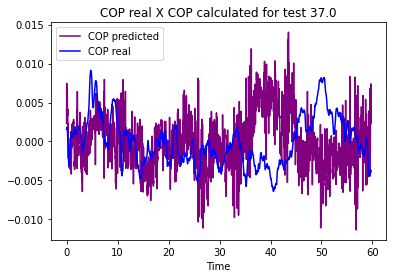

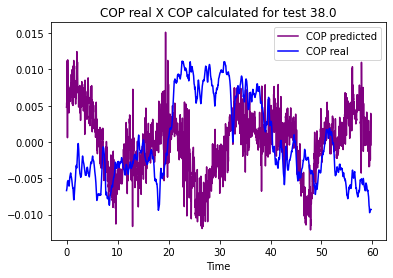

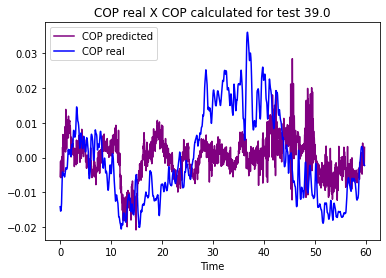

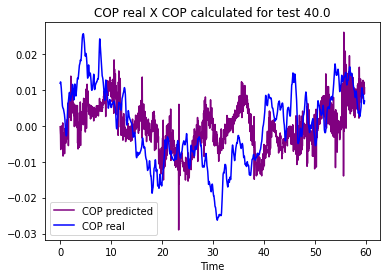

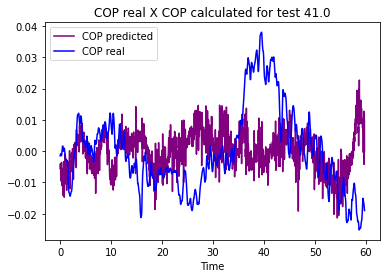

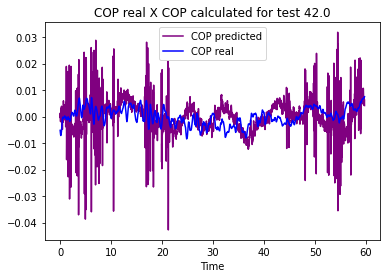

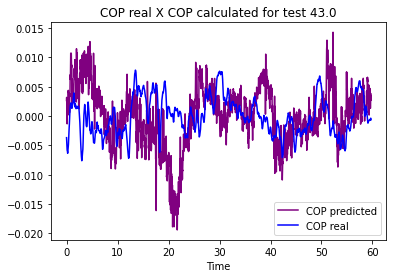

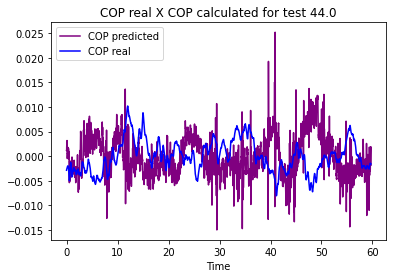

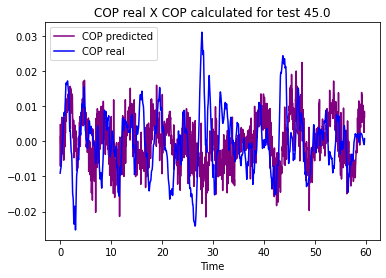

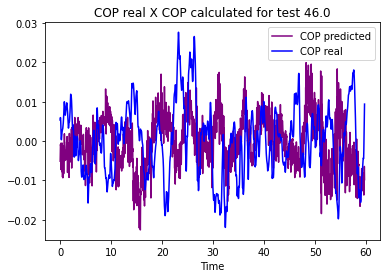

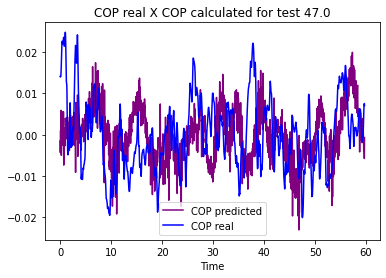

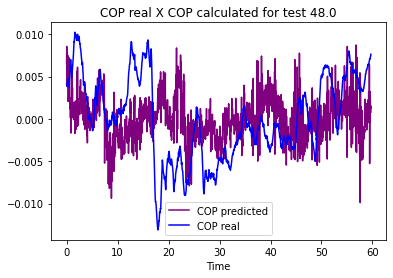

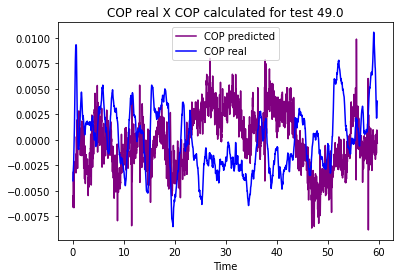

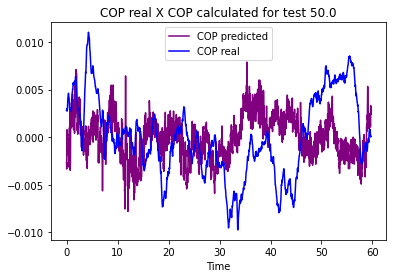

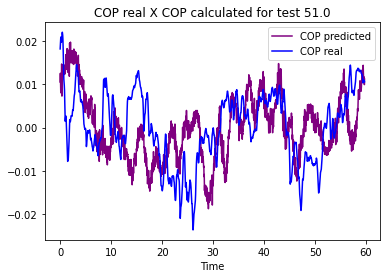

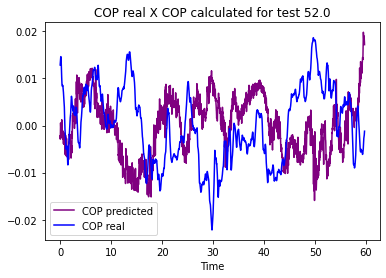

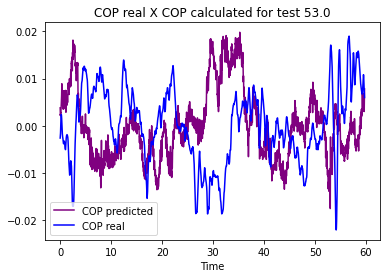

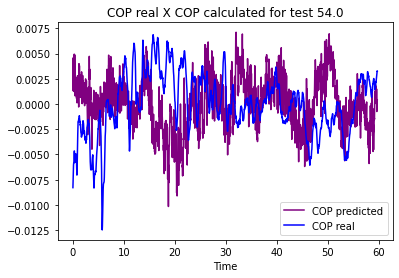

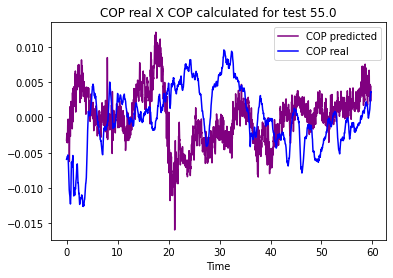

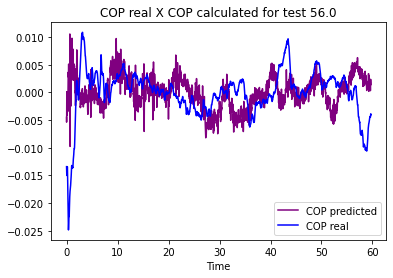

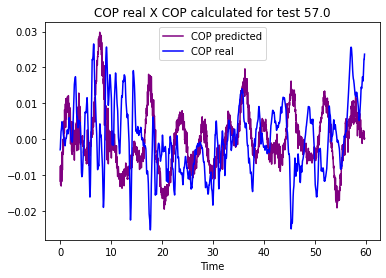

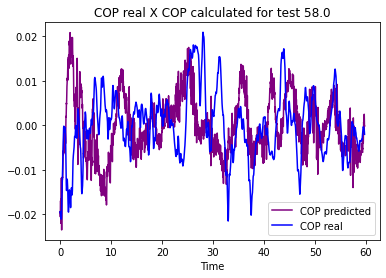

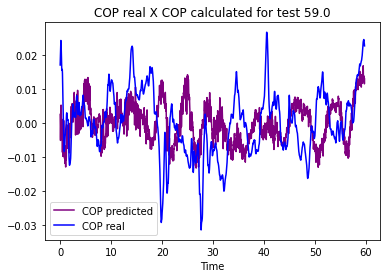

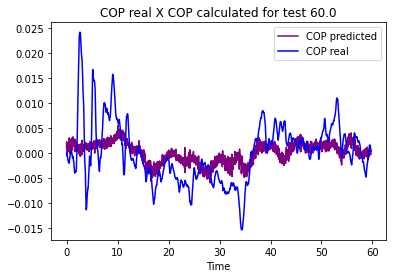

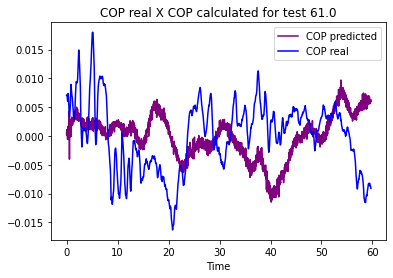

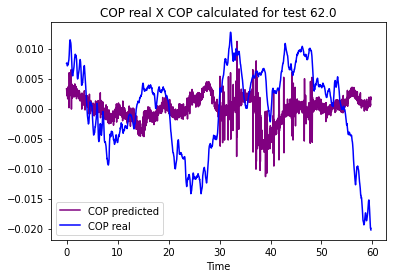

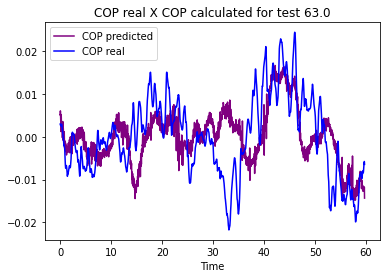

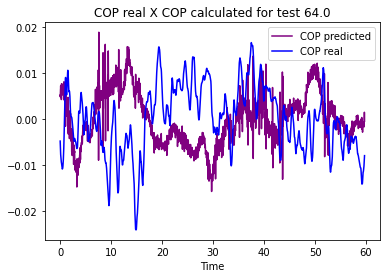

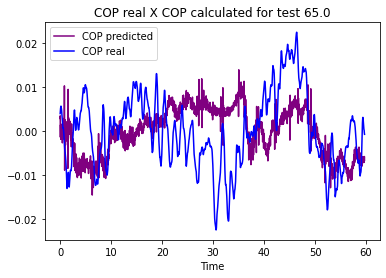

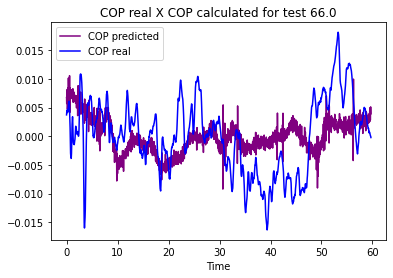

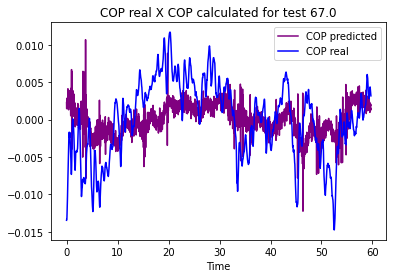

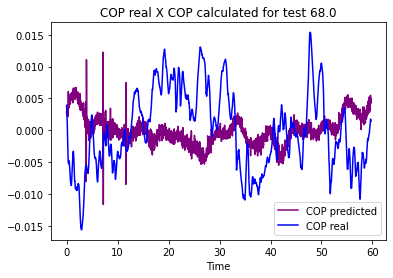

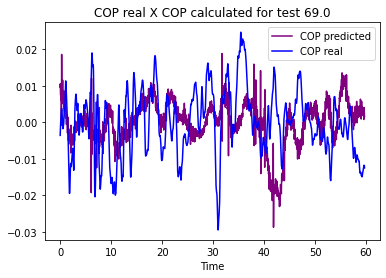

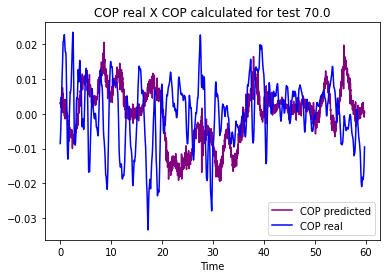

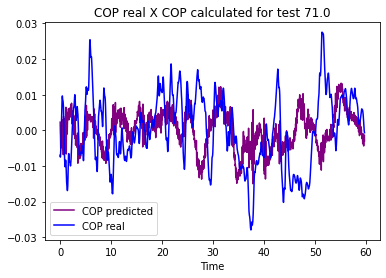

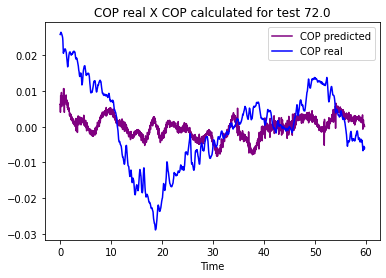

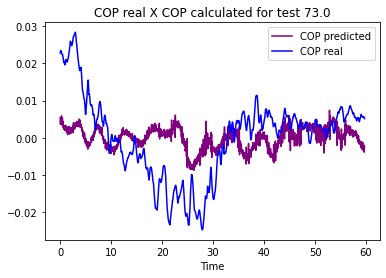

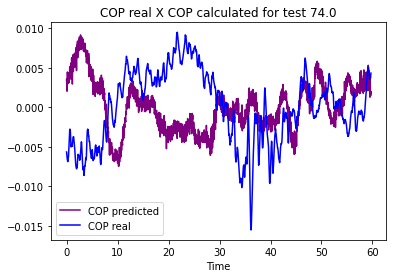

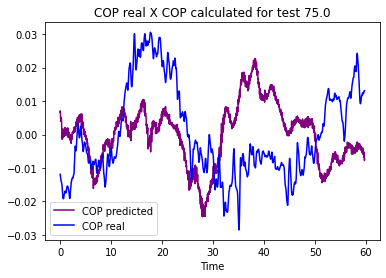

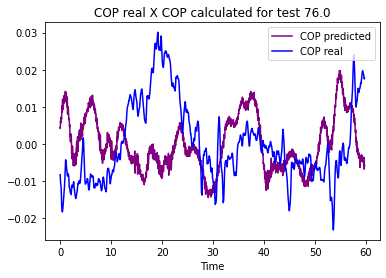

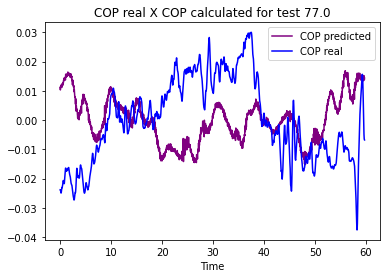

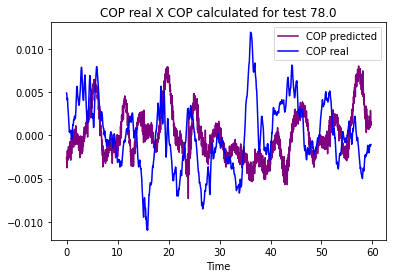

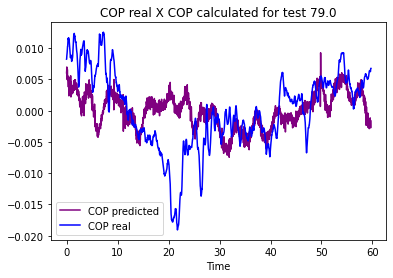

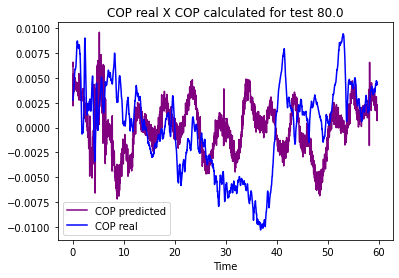

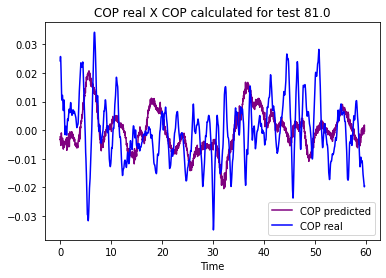

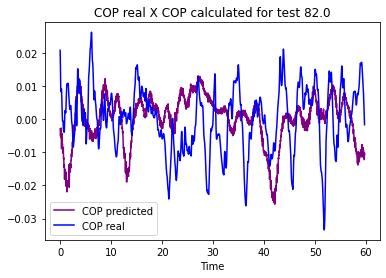

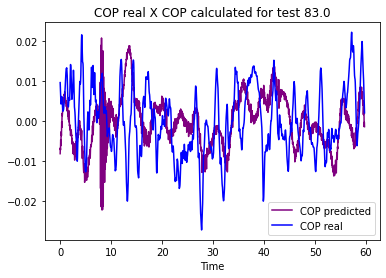

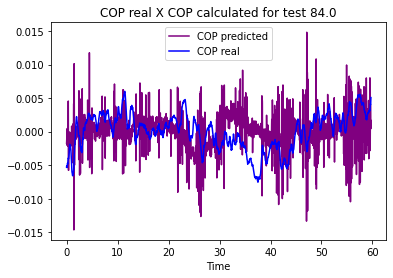

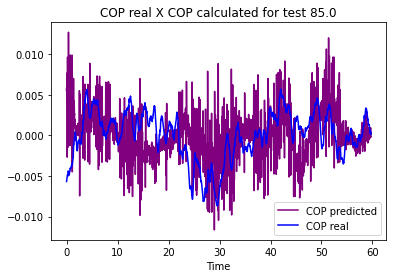

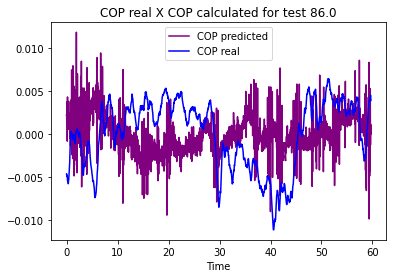

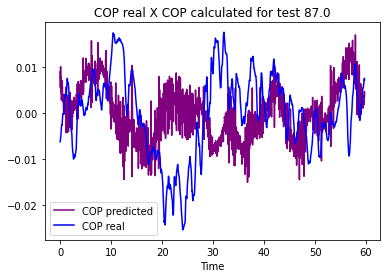

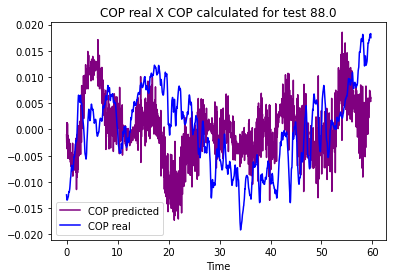

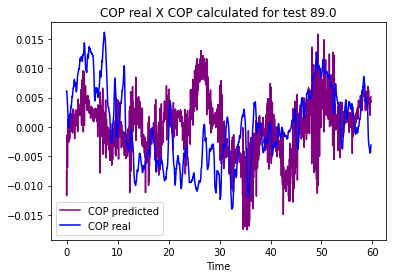

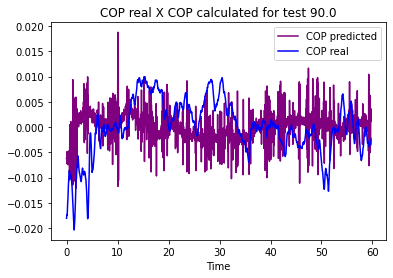

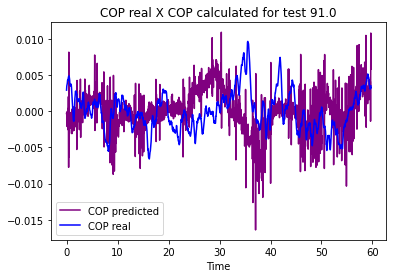

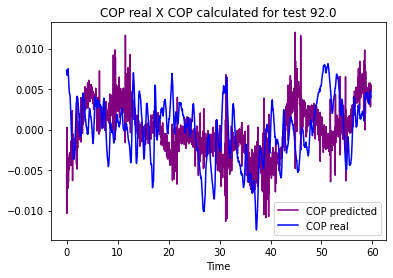

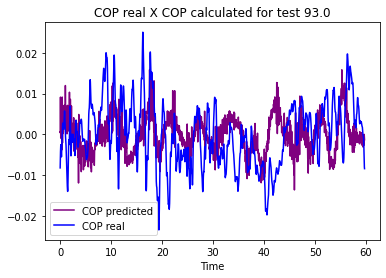

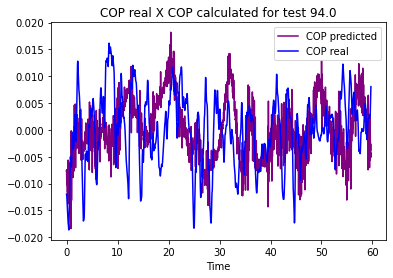

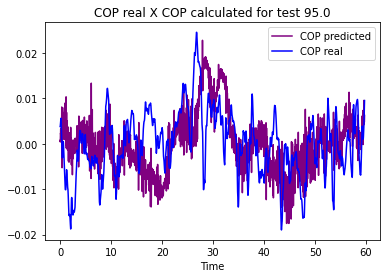

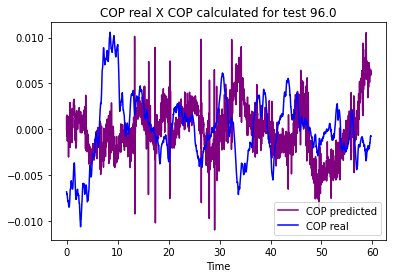

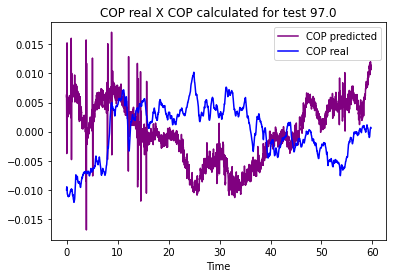

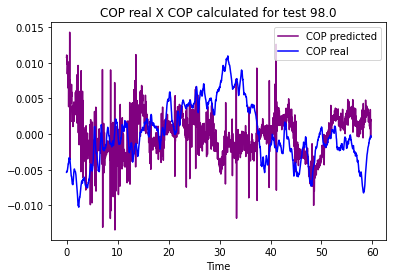

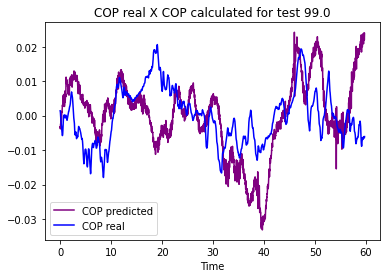

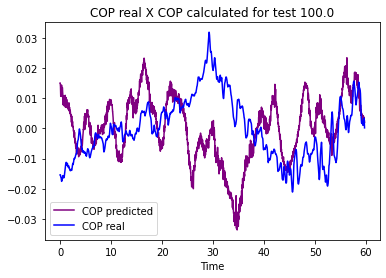

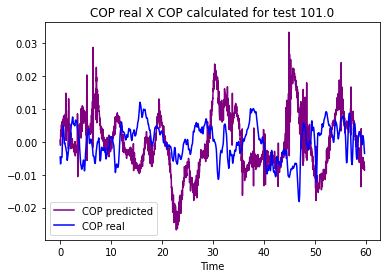

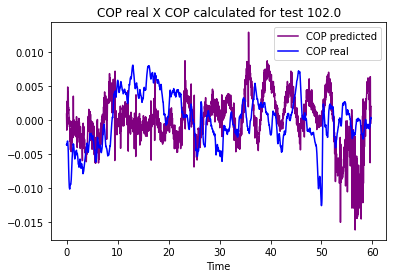

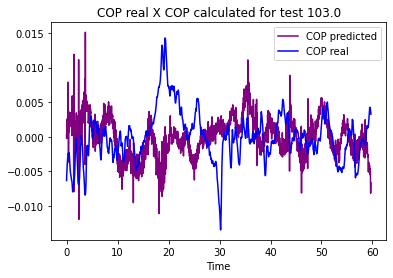

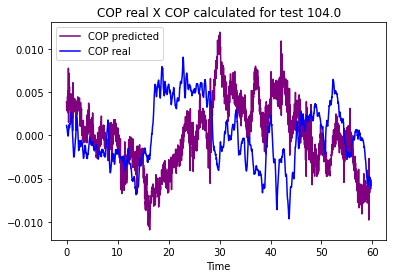

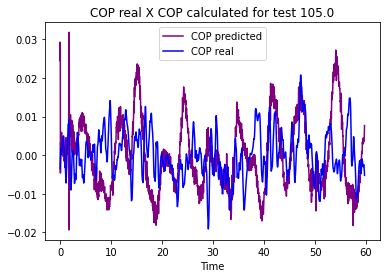

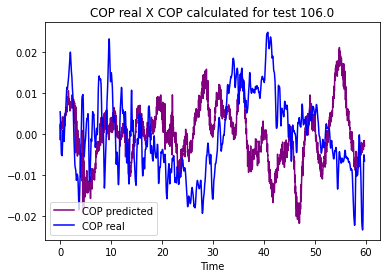

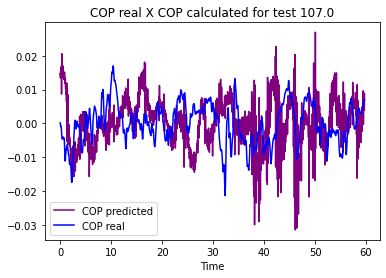

(5970,)

In [15]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
COPXES = np.zeros((len(COGXtest), 60*fs-30))
COPXESorig =np.zeros((len(COGXtest), 60*fs-30))
for u in range(0,len(COGXtest)):
    d = np.sqrt(COGXtest[u]**2+COGYtest[u]**2+COGZtest[u]**2)
    angulox = np.arcsin(COGXtest[u]/d)
    anguloz = np.arcsin(COGZtest[u]/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[u,:] = angulox
    matrizangz[u,:] = anguloz
    
    Jb=(4/3)*(mass.values[s])*((d)**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[u,:]=np.gradient(matrizangx[u,:],dt)
    d1z[u,:]=np.gradient(matrizangz[u,:],dt)
    
    

    d2x[u,:]=np.gradient(d1x[u,:],dt)
    d2z[u,:]=np.gradient(d1z[u,:],dt)
    
    
    COPX[u,:] = d*sinx + Jb/(mass.values[s]*9.8)*(sinx*d1x[u,:]**2-cosx*d2x[u,:])
    
    
    #COPXES[u,:] = alfamedia* COPX[u,:] + betamedia*(d2x[u,:])
    
    COPXES[u,:] = alfamedia*(d*sinx + ((Jb/(mass.values[s]*9.8))*sinx*d1x[u,:]**2)) + d2x[u,:]*(-alfamedia*cosx*Jb/(mass.values[s]*9.8)+betamedia)
    COPXESorig[u,:]= COPX[u,:]
    
print((detrend(COPXES[i,:])).shape)
print(COPXES)
print (COPXESorig.shape)
print(COGXtest.shape)
time = np.arange(0,6000)/100
for i in range(0,len(COGXtest)):
    plt.figure()
    plt.plot(time[:5970],detrend(COPXES[i,:]),color='purple',label='COP predicted')
    plt.plot(time[:5970],detrend(COPXreal[i]),color='blue', label='COP real')
    plt.title('COP real X COP calculated for test {:.1f}'.format(i))
    plt.xlabel('Time')
    plt.legend()
    plt.show()
(detrend(COPXES[i,:])).shape

Error from COPXESorig 

In [10]:
from sklearn.metrics import mean_squared_error
ytrue = COPXtest
ypredicted = COPXESorig
mean_squared_error(ytrue, ypredicted)

0.000695800636528237

In [11]:
erro= (COPXtest - COPXESorig)**2
print(erro.mean())

0.0006958006365282372


Error from COPXES

In [12]:
from sklearn.metrics import mean_squared_error
ytrue = COPXtest
ypredicted = COPXES
mean_squared_error(ytrue, ypredicted)

0.0007706369090435172

In [13]:
erro= (COPXtest - COPXES)**2
print(erro.mean())

0.0007706369090435175
